In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Kullanılan Kütüphaneler
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(15.0,12.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

In [3]:
%cd /content/gdrive/MyDrive/
!mkdir TextRecognition
%cd TextRecognition

/content/gdrive/MyDrive
/content/gdrive/MyDrive/TextRecognition


In [4]:
# Githubdan ilgili repository'nin çalışma klasörümüze eklenmesi ve önceden eğitilmiş modelin indirilmesi

!git clone https://github.com/clovaai/deep-text-recognition-benchmark.git
%cd deep-text-recognition-benchmark

!mkdir pths

%cd pths

!gdown https://drive.google.com/uc?id=1b59rXuGGmKne1AuHnkgDzoYgKeETNMv9

%cd /content/gdrive/MyDrive/TextRecognition/deep-text-recognition-benchmark

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (301/301), done.
/content/gdrive/MyDrive/TextRecognition/deep-text-recognition-benchmark
/content/gdrive/MyDrive/TextRecognition/deep-text-recognition-benchmark/pths
Downloading...
From: https://drive.google.com/uc?id=1b59rXuGGmKne1AuHnkgDzoYgKeETNMv9
To: /content/gdrive/MyDrive/TextRecognition/deep-text-recognition-benchmark/pths/TPS-ResNet-BiLSTM-Attn.pth
100% 199M/199M [00:01<00:00, 115MB/s]
/content/gdrive/MyDrive/TextRecognition/deep-text-recognition-benchmark


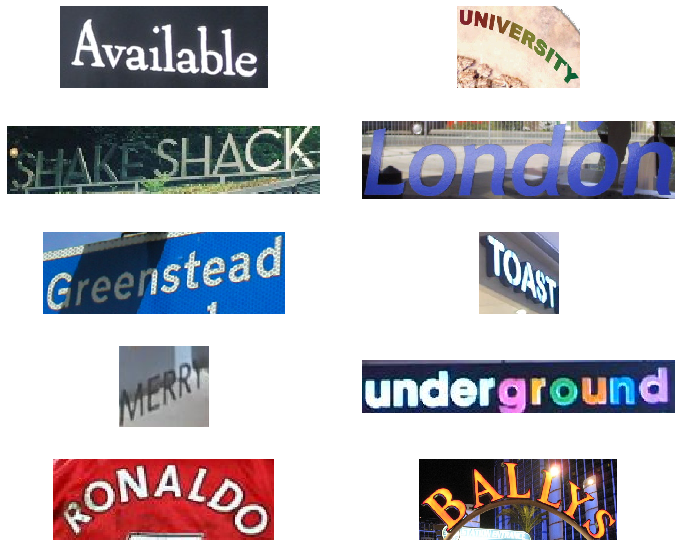

In [6]:
plt.rcParams['figure.figsize']=(10.0,8.0)
img_path='demo_image'
resim_dosyalari=os.listdir(img_path)
f,axarr=plt.subplots(5,2)
f.tight_layout()
for i in range(5):
  for j in range (2):
    resim_dosyasi=os.path.join(img_path,resim_dosyalari[i*2+j])
    axarr[i,j].imshow(Image.open(resim_dosyasi))
    axarr[i,j].axis('off')
f.show()
plt.rcParams['figure.figsize']=(15.0,12.0)


In [8]:
!python demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder demo_image/ \
--saved_model pths/TPS-ResNet-BiLSTM-Attn.pth


model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from pths/TPS-ResNet-BiLSTM-Attn.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
------

## Daha Detaylı

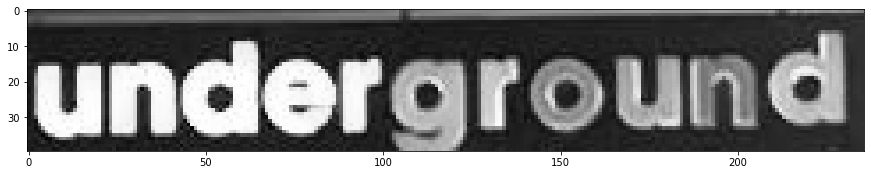

In [40]:
resim_dosyasi='demo_image/demo_7.png'
model_dosyasi='pths/TPS-ResNet-BiLSTM-Attn.pth'

resim=Image.open(resim_dosyasi).convert('L')
plt.imshow(resim)
plt.show()

In [41]:
# Model içersinde Configurasyon
from model import Model
from utils import AttnLabelConverter
class ModelParameters:
  def __init__(self):
        self.character = '0123456789abcdefghijklmnopqrstuvwxyz'
        self.Transformation = 'TPS'
        self.FeatureExtraction = 'ResNet'
        self.SequenceModeling = 'BiLSTM'
        self.Prediction = 'Attn'
        self.num_fiducial = 20
        self.output_channel = 512
        self.hidden_size = 256
        self.imgH = 32  # modele verilecek resmin boyu
        self.imgW = 100  # modele verilecek resmin eni
        self.input_channel = 1  # model siyah beyaz resimler üzerinde çalışıyor
        self.num_class = len(self.character) + 2  # buradaki +2, tahmine başlangıç ve bitiş iki özel karakteri için ekleniyor
        self.batch_max_length = 25

opt=ModelParameters()

#Tahminin maximum karakter sayısı ve metnin tahmininin tutulacağı değişkenler

tahminin_uzunluğu=torch.cuda.IntTensor([opt.batch_max_length])
tahminin_metni=torch.cuda.LongTensor(1,opt.batch_max_length+1).fill_(0)

# Modelin tahminlerini metne çevirme
converter=AttnLabelConverter(opt.character)

# Modelin Oluşturulması ve pretrained modelin yüklenmesi
model=Model(opt)

#Troch.nn.DataParallel ile eğitilen modeller yine bu şekilde çağrılmalıdır
model=torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load(model_dosyasi))

<All keys matched successfully>

In [42]:
from dataset import ResizeNormalize
# Resmin modele verilmesi için yeniden boyutlandırılması
# Resmin pytorch tensorüne dönüştürülmesi
#resmin normalize edilmesi
donusturucu=ResizeNormalize((opt.imgW,opt.imgH)) 
# gerekli işlemlerden sonra Gpu ya taşıma
resim_tensoru=donusturucu(resim).cuda()
resim_tensoru=resim_tensoru.view(1,*resim_tensoru.size())


underground


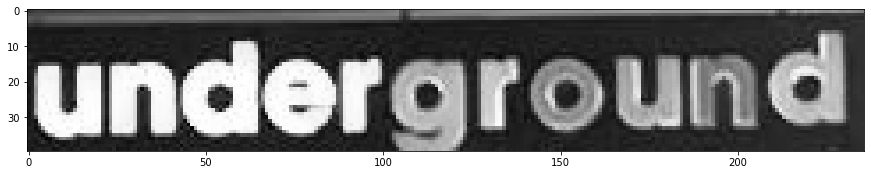

In [43]:
tahmin=model(resim_tensoru,tahminin_metni,is_train=False)
# En yüksek ihtimalle tahmin edilen karakterlerin indexlerini çıkarır.
_,tahmin_indexi=tahmin.max(2)
# buradaki 0 resim sayımız sadece 1 olduğundan ilk elemanı almak için kullanılıyor.

tahmin_dizisi=converter.decode(tahmin_indexi,tahminin_uzunluğu)[0]

#Bitiş karakterinin ([s]) ile çıkarılması.
tahmin_dizisi=tahmin_dizisi[:tahmin_dizisi.find('[s]')]

print(tahmin_dizisi)
plt.imshow(resim)
plt.show()